In [11]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.combine import SMOTEENN
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('nltk-data')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jeyanth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading nltk-data: Package 'nltk-data' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jeyanth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
TAMIL_STOPWORDS = [
    "அது", "இது", "என்று", "இருந்து", "அவர்", "நீங்கள்", "என", "இவை", "தான்", "தன்மை",
    "கூட", "அவர்கள்", "இங்கே", "அங்கு", "தமக்கு", "என்ன", "மற்றும்", "இப்போது", "அதனால்",
    "உடன்", "இதனால்", "இந்த", "அந்த", "எது", "எவ்வாறு", "கிட்டத்தட்ட", "அவனை", "தோன்றும்",
    "என்பது", "ஆகும்", "உள்ள", "அதிக", "சில", "எல்லா", "மிகவும்", "நான்", "எங்கு", "அப்போது"
]

In [18]:
# Text preprocessing functions
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s#]', '', text)  # Retain hashtags
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_hashtags(text):
    """Extract and process hashtags."""
    hashtags = re.findall(r'#(\w+)', text)  # Extract hashtags
    return ' '.join(hashtags)  # Return space-separated hashtags

def preprocess_text(text):
    text = str(text)
    text = normalize_text(text)
    
    # Extract hashtags and append to text
    hashtags = extract_hashtags(text)
    text += " " + hashtags
    
    tokens = word_tokenize(text)
    tokens = [
        word for word in tokens
        if word not in stopwords.words('english') and word not in TAMIL_STOPWORDS
    ]
    return ' '.join(tokens)

In [34]:
# Load datasets
train_df1 = pd.read_csv(r'input/PS_train.csv')
train_df2 = pd.read_csv(r'input/PS_dev.csv')
test_df = pd.read_csv(r'input/test.csv')

In [24]:
nltk.data.path.append('C:\\SharedTask\\.venv\\Lib\\site-packages\\nltk')

In [27]:
# Combine training datasets
train_df = pd.concat([train_df1, train_df2], ignore_index=True)

# Preprocess text data
train_df['processed_text'] = train_df['content'].apply(preprocess_text)

In [28]:
# Map labels to integers
labels_map = {
    "Negative": 0, "Neutral": 1, "None of the above": 2, "Opinionated": 3,
    "Positive": 4, "Sarcastic": 5, "Substantiated": 6
}
train_df['label'] = train_df['labels'].map(labels_map)

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 3))
X = vectorizer.fit_transform(train_df['processed_text'])
y = train_df['label']

# Check class distribution
print("Original class distribution:", Counter(y))

Original class distribution: Counter({3: 1514, 5: 905, 1: 721, 4: 644, 6: 464, 0: 457, 2: 191})


In [29]:
# Handle class imbalance using SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X, y)

# Verify new class distribution
print("Resampled class distribution:", Counter(y_resampled))

Resampled class distribution: Counter({2: 1346, 0: 1100, 6: 1040, 4: 716, 1: 565, 5: 470, 3: 47})


In [30]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize Support Vector Classifier
svc = SVC(random_state=42)

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='f1_macro')

In [31]:
# Best model from grid search
best_model = grid_search.best_estimator_

# Evaluate on validation set
y_pred = best_model.predict(X_val)
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"Macro F1 Score: {macro_f1}")
print(classification_report(y_val, y_pred, target_names=list(labels_map.keys())))

Macro F1 Score: 0.9595011246076481
                   precision    recall  f1-score   support

         Negative       0.96      1.00      0.98       237
          Neutral       0.92      0.86      0.89       115
None of the above       1.00      1.00      1.00       254
      Opinionated       1.00      0.89      0.94         9
         Positive       0.96      0.96      0.96       139
        Sarcastic       1.00      0.96      0.98        90
    Substantiated       0.97      0.98      0.98       213

         accuracy                           0.97      1057
        macro avg       0.97      0.95      0.96      1057
     weighted avg       0.97      0.97      0.97      1057



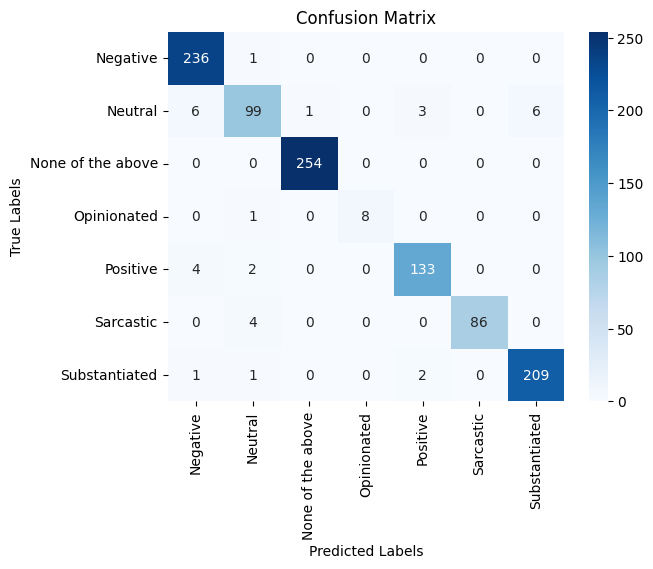

In [32]:
# Confusion matrix visualization
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.keys(), yticklabels=labels_map.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [35]:
# Preprocess and vectorize test data
test_df['processed_text'] = test_df['content'].apply(preprocess_text)
X_test = vectorizer.transform(test_df['processed_text'])

In [36]:
# Predict on test data
test_predictions = best_model.predict(X_test)
test_df['Labels'] = test_predictions
label_map_reverse = {v: k for k, v in labels_map.items()}
test_df['Labels'] = test_df['Labels'].map(label_map_reverse)

In [38]:
# Save predictions to a CSV file
test_df[['Id', 'Labels']].to_csv('input/result1.csv', index=False)

In [39]:
# Evaluate on validation set
y_pred = best_model.predict(X_val)
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"Macro F1 Score: {macro_f1}")
print(classification_report(y_val, y_pred, target_names=list(labels_map.keys())))

Macro F1 Score: 0.9595011246076481
                   precision    recall  f1-score   support

         Negative       0.96      1.00      0.98       237
          Neutral       0.92      0.86      0.89       115
None of the above       1.00      1.00      1.00       254
      Opinionated       1.00      0.89      0.94         9
         Positive       0.96      0.96      0.96       139
        Sarcastic       1.00      0.96      0.98        90
    Substantiated       0.97      0.98      0.98       213

         accuracy                           0.97      1057
        macro avg       0.97      0.95      0.96      1057
     weighted avg       0.97      0.97      0.97      1057

